# NSPP via thinning

This notebook apply thinning to the CCU weekday parameters.

::: {.callout-caution collapse="true"}
## Thinning overview

Thinning is an acceptance-rejection approach to sampling inter-arrival times (IAT) from a time dependent distribution where each time period follows its own exponential distribution.

There are two random variables employed in sampling: an exponential distribution (used to sample IAT) and a uniform distibution (used to accept/reject samples).

All IATs are sampled from an Exponential distribution with the highest arrival rate (most frequent). These arrivals are then rejected (thinned) proportional to the ratio of the current arrival rate to the maximum arrival rate.  The algorithm executes until a sample is accepted.  The IAT returned is the sum of all the IATs that were sampled.

:::


::: {.callout-caution collapse="true"}
## The thinning algorithm

A NSPP has arrival rate $\lambda(t)$ where $0 \leq t \leq T$

Here $i$ is the arrival number and $\mathcal{T_i}$ is its arrival time.

1. Let $\lambda^* = \max_{0 \leq t \leq T}\lambda(t)$ be the maximum of the arrival rate function and set $t = 0$ and $i=1$

2. Generate $e$ from the exponential distribution with rate $\lambda^*$ and let $t = t + e$ (this is the time of the next entity will arrive)

3. Generate $u$ from the $U(0,1)$ distribution.  If $u \leq \dfrac{\lambda(t)}{\lambda^*}$ then $\mathcal{T_i} =t$ and $i = i + 1$

4. Go to Step 2.

:::



## `sim-tools` imports

In [1]:
from sim_tools.datasets import load_banks_et_al_nspp
from sim_tools.time_dependent import NSPPThinning

## general imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import simpy
import itertools

plt.style.use('ggplot')

## Load data

In [3]:
ccu_arrival_profile_week = pd.read_csv('./data/weekday_profile.csv')
ccu_arrival_profile_week.round(1)

,t,arrival_rate,mean_iat
0,0,1.1,55.5
1,60,1.3,46.1
2,120,0.9,69.3
3,180,0.9,67.2
4,240,0.7,85.1
5,300,0.7,81.1
6,360,0.7,90.0
7,420,0.5,115.1
8,480,0.4,145.0
9,540,0.4,141.1


## Model

We define a simple experiment and Time Dependent model used only for counting the number of arrivals in an hour using thinning.

> `simpy` is used in a way to control for a fixed number of arrivals rather than a given run length.

In [4]:
class Experiment:
    def __init__(self, arrival_profile,
                 random_no_set=None):
        self.arrival_profile = arrival_profile

    def init_sampling(self, random_no_set=None):
        # producing 2 non-overlapping streams
        seed_sequence = np.random.SeedSequence(random_no_set)
        self.seeds = seed_sequence.spawn(2)
        
        self.nspp_rng = NSPPThinning(self.arrival_profile, self.seeds[0], 
                                     self.seeds[1])
        

In [5]:
class TimeDependentModel:
    def __init__(self, env, experiment):
        self.env = env
        self.experiment = experiment
        # create array hold arrivals per hour of day.
        self.hour_samples = [0] * experiment.arrival_profile.shape[0]
        self.arrival_times = []
        self.n_arrivals = 0

    def arrivals_generator(self):
        for _ in itertools.count():
            # simulated arrival
            interarrival_time = self.experiment.nspp_rng.sample(self.env.now)
            yield self.env.timeout(interarrival_time)

            # Store the arrival time
            self.arrival_times.append(self.env.now)

            # store the IAT
            
                
            # VERIFICATION: add one to count for hour of the day
            hour_of_day = int(self.env.now // 60) % \
                self.experiment.arrival_profile.shape[0]
            self.hour_samples[hour_of_day] += 1
            self.n_arrivals += 1
            

In [6]:
def single_run(experiment, run_length=1440, random_no_set=0):
    """
    Run a single replication of the model.
    """
    # sim environment
    env = simpy.Environment()
    experiment.init_sampling(random_no_set)
    # create experiment and parameterise model
    model = TimeDependentModel(env, experiment)

    # set up simpy processes.
    env.process(model.arrivals_generator())
    env.run(run_length)

    return model
    

In [7]:
def multiple_replications(experiment, run_length=1440, n_reps=5):
    '''
    Perform multiple replications of the model.
    
    Params:
    ------
    experiment: Experiment
        Parameters/arguments to configure the model
    
    run_length: float, optional (default=6540)
        results collection period in minutes.
        the number of minutes to run the model to collect results

    n_reps: int, optional (default=5)
        Number of independent replications to run.
        
    Returns:
    --------
    pandas.DataFrame
    '''

    results = [single_run(experiment, run_length, rep) 
               for rep in range(n_reps)]

    arrival_hours = [model.hour_samples for model in results]
    arrival_times = [model.arrival_times for model in results]
    
    # format and return results in a dataframe
    df_hr_results = pd.DataFrame(arrival_hours)
    df_hr_results.index = np.arange(1, len(df_hr_results)+1)
    df_hr_results.index.name = 'rep'

    arrival_times = np.concatenate(arrival_times).flatten()
        
    return df_hr_results, arrival_times


In [8]:
# create experiment and parameterise model
experiment = Experiment(ccu_arrival_profile_week)
hr_results, arrival_times = multiple_replications(experiment, run_length=1440, n_reps=10_000)

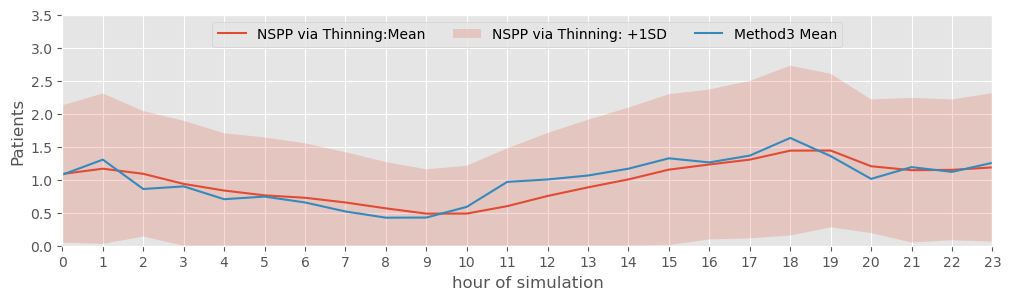

In [15]:
hour_means = hr_results.mean(axis=0)
hour_sd = hr_results.std(axis=0) 

upper = hour_means + hour_sd
lower = hour_means - hour_sd
lower[lower < 0] = 0

# visualise
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot()

# chart x ticks
x_values = np.arange(0, ccu_arrival_profile_week.shape[0])

# plot in this case returns a 2D line plot object
_ = ax.plot(hour_means, label="NSPP via Thinning:Mean")
_ = ax.fill_between(x_values, lower, upper, alpha=0.2, label='NSPP via Thinning: +1SD')

# read in mthod 3
method3 = pd.read_csv("./ccu_method3.csv")
_ = ax.plot(method3["mean"], label="Method3 Mean")

# chart appearance
_ = ax.legend(loc="upper center", ncol=3)
_ = ax.set_ylim(0, 3.5)
_ = ax.set_xlim(0, 23)
_ = ax.set_ylabel("Patients")
_ = ax.set_xlabel("hour of simulation")
_ = plt.xticks(np.arange(0, ccu_arrival_profile_week.shape[0]))

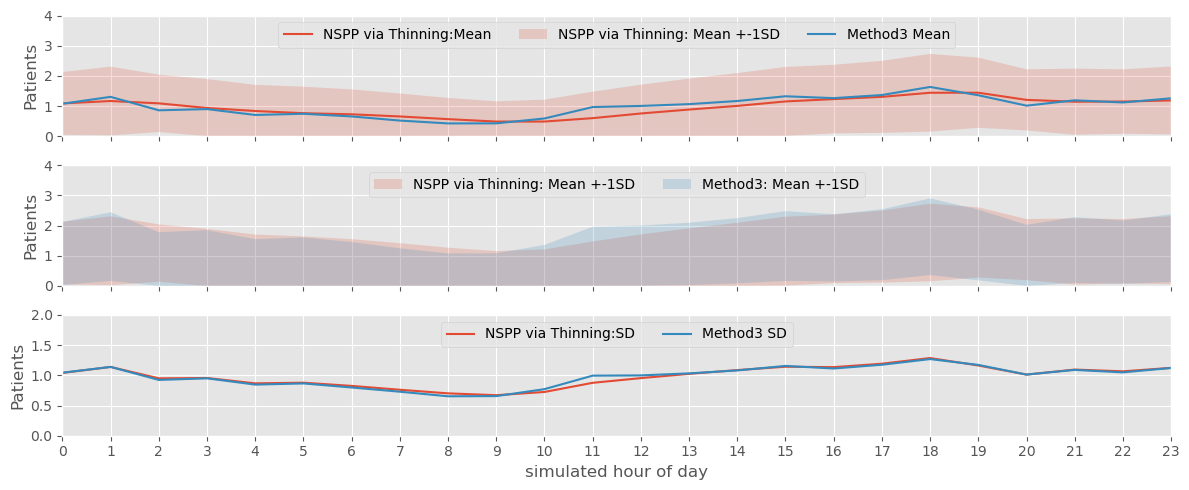

In [45]:
method3 = pd.read_csv("./ccu_method3.csv")

# create figure and subplots
fig, axs = plt.subplots(nrows=3, ncols=1, tight_layout=True, figsize=(12,5),
                        sharex=True)

# 0 to 23 for x axis
x_values = np.arange(0, ccu_arrival_profile_week.shape[0])

# top plot is main comparison
_ = axs[0].plot(hour_means, label="NSPP via Thinning:Mean")
_ = axs[0].fill_between(x_values, lower, upper, alpha=0.2, label='NSPP via Thinning: Mean +-1SD')
_ = axs[0].plot(method3["mean"], label="Method3 Mean")

# compare Mean +- 1*SDs
_ = axs[1].fill_between(x_values, lower, upper, alpha=0.2, label='NSPP via Thinning: Mean +-1SD')
_ = axs[1].fill_between(x_values, method3["-1SD"], method3["+1SD"], alpha=0.2, label='Method3: Mean +-1SD')

# compare SD  
_ = axs[2].plot(hour_sd, label="NSPP via Thinning:SD")
_ = axs[2].plot(method3["sd"], label="Method3 SD")

for ax in axs:
    _ = ax.set_ylim(0, 4.0)
    _ = ax.set_xlim(0, 23)
    _ = ax.set_ylabel("Patients")
    _ = ax.legend(loc="upper center", ncol=3)

# format axes
_ = plt.xticks(x_values)

_ = axs[2].set_ylim(0, 2.0)
_ = axs[2].set_xlabel("simulated hour of day")

fig.savefig("./comparison_weekday.png")

## Time within an hour variation

Note that unlike method3, the NSPP via thinning approach is continuous and provides variation within an hour.

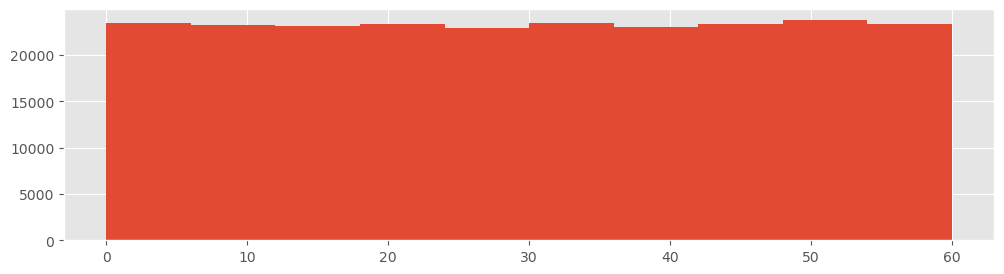

In [10]:
# visualise

fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot()

_ = ax.hist(arrival_times % 60.0)